# Optimization with CVWPY 

In [1]:
%pylab inline
import time
import numpy as np
import cvxpy as cvx
import matplotlib.pyplot as plt
from utils import img_utils
import seaborn as sns
import utils.math_utils as mu

Populating the interactive namespace from numpy and matplotlib


In [2]:
reload(img_utils)

<module 'utils.img_utils' from 'utils/img_utils.pyc'>

## Load DWI

In [3]:
from utils.DataGetter import DataGetter
from utils.DownsampledImage import DownsampledImage

d = DataGetter()
datas_names = [
    DataGetter.STANDFORD_HARDI_DATA, #(81, 106, 76, 160)
    #DataGetter.TAIWAN_NTU_DSI_DATA,  #(96, 96, 60, 203)
    #DataGetter.SHERBROOKE_3SHELL_DATA #(128, 128, 60, 193)
]

scale=2
datas = d.get_data(datas_names)
name = datas_names[0]
lr_hr_img = DownsampledImage(name, datas[name]['img'], datas[name]['gtab'], scale)

NORMALIZE = False
if NORMALIZE :
    img_hr = mu.normalize_by_bval(lr_hr_img.get_hr_img().astype(float))
    img_lr = mu.normalize_by_bval(lr_hr_img.get_lr_img().astype(float))
else:
    img_hr = lr_hr_img.get_hr_img().astype(float)
    img_lr = lr_hr_img.get_lr_img().astype(float)
    

/user/lgomez/home/anaconda2/lib/python2.7/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


Dataset is already in place. If you want to fetch it again please first remove the folder /user/lgomez/home/.dipy/stanford_hardi 
Dataset is already in place. If you want to fetch it again please first remove the folder /user/lgomez/home/.dipy/stanford_hardi 


## Select Area of Interest

('b=2000, G directions =',
 array([[  2.18280000e-02,   8.02420000e-01,  -5.96360000e-01],
        [ -1.54250000e-02,   2.20980000e-01,   9.75160000e-01],
        [ -7.09180000e-01,  -6.31060000e-04,  -7.05030000e-01],
        [ -2.46500000e-01,   1.04300000e-01,  -9.63510000e-01],
        [ -4.83470000e-01,   4.39100000e-01,  -7.57260000e-01],
        [  1.51030000e-01,   9.65230000e-01,   2.13360000e-01]]))

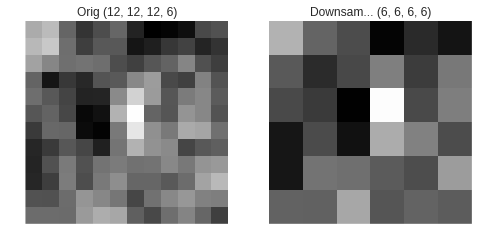

In [4]:
img_shape = img_lr.shape
x0,xf, y0,yf, z0,zf = volume_range_lr = (10, 16, 15, 21, 13, 19)
#x0,xf, y0,yf, z0,zf = volume_range_lr = (16, 16+6, 11, 17, 15, 21)
b0, bf = bval_range = (10,16)
gdirections = lr_hr_img.gtab.bvecs[b0:bf]

# Type and intensiti of noise to apply
SNR, SNR_TYPE = 50, 'gaussian'

#img_hr[2*x0:2*xf, 2*y0:2*yf, 2*z0:2*zf, b0:bf] = (img_hr[2*x0:2*xf, y0, 2*z0:2*zf, b0:bf].max())*np.ones((12,12,12,6))

i_lr = img_lr[x0:xf, y0:yf, z0:zf, b0:bf]
i_hr = img_hr[2*x0:2*xf, 2*y0:2*yf, 2*z0:2*zf, b0:bf]

img_utils._isc(i_hr,i_lr,titles=['Orig '+ str(i_hr.shape), 'Downsam... '+str(i_lr.shape)] )
'b=2000, G directions =', gdirections


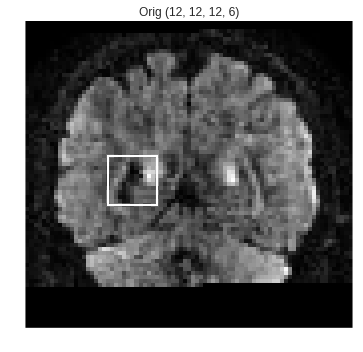

HR max,min 0.0 13321.0
(30, 20, 12, 12)


In [35]:
reload(img_utils)

rect_hr = 2*(z0+2), 2*x0, 2*xf-2*x0, 2*zf-2*z0

img_utils._iswr(img_hr[:,2*y0:2*yf,:,10:16],  rect_hr, b=1,title='Orig '+ str(i_hr.shape))
print 'HR max,min', img_hr.min(), img_hr.max()
print rect_hr

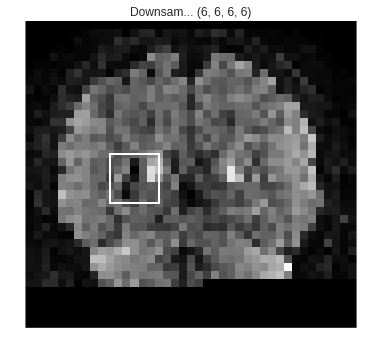

LR max,min 0.0 12067.0
(15, 10, 6, 6)


In [34]:
reload(img_utils)

rect_lr = z0+2, x0, xf-x0, zf-z0

img_utils._iswr(img_lr[:,y0:yf,:,10:16], rect_lr,b=1, title='Downsam... '+str(i_lr.shape))
print 'LR max,min', img_lr.min(), img_lr.max()
print rect_lr

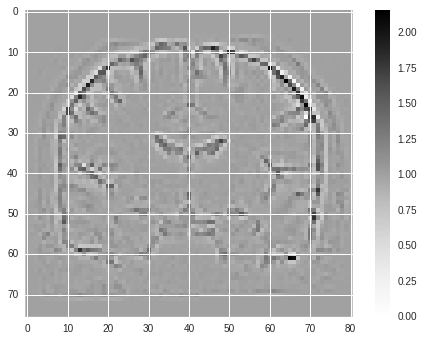

In [18]:
import scipy.ndimage.filters as fil

imgd = np.rot90(mu.normalize(fil.laplace(img_hr[:,img_hr.shape[1]/2,:,0])))

imshow(1-imgd, interpolation='none')
colorbar()


# Predicting the G downsampling Matrix

In [9]:
import utils.RandomRanges as rr
import utils.DmriVolumesRandomIndexers as ixs
import utils.DmriSampleCreators as sc
import utils.ml.MLDataBuilder as db


# Estrategia de volumne y rango de bvals (fija)
volume_strategy, bval_strategy = rr.Fixed3DRange(*volume_range_lr), rr.Fixed1DRange(*bval_range)
# El que combina ambas
dmri_volume_indexer = ixs.DmriVolumeRandomIndexer(volume_strategy, bval_strategy)
# Equivalencia entre indices de la hr y lr 
fconvert = lambda *lr_tuple : tuple(np.array(lr_tuple[:-2])*2)+lr_tuple[-2:]
# Iterador de dmri imagen lr y hr
lr_hr_vol_it = ixs.DmriLrHrCubicPatchVolumeRandomIndexer(dmri_volume_indexer, fconvert, from_lr2hr=True)

# El que toma la imagen original y downsampleada y les pone ruido (gaussian, rician)
sample_creator = sc.NoisedLrHrDmriSampleCreator(lr_hr_img, lr_hr_vol_it, snr=SNR, noise_type=SNR_TYPE)


n_samples = 10

# Builder that organize data like the ML wants 
sdb = db.SimpleMlDataBuilder(sample_creator, n_samples)

X, Y = sdb.build()
print X.shape, Y.shape

Samples for  standfor_hardi : 10 of inf
(1296, 10) (10368, 10)


In [6]:
reload(rr)
reload(sc)
reload(db)
reload(ixs)
import utils.dmri_patch_operations.DmriPatch as patchs
reload(patchs)

<module 'utils.dmri_patch_operations.DmriPatch' from 'utils/dmri_patch_operations/DmriPatch.pyc'>

<module 'matplotlib.pyplot' from '/user/lgomez/home/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

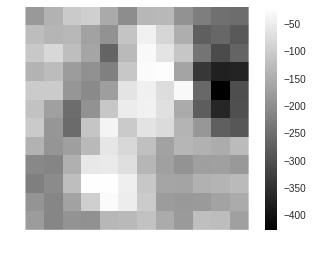

In [10]:
img_utils._is(i_hr-Y[:, 1].reshape(i_hr.shape), b=1)

m1 min:max 0.00452488687783 0.545248868778
m2 min:max -4.0 488.0
dif min:max -487.454751131 4.01696832579
difcuad min:max 0.000154839172007 237612.1344
mse, sqrt(mse)= 32493.5167233 180.259581502
coef_det= m1 min:max 0.00452488687783 0.545248868778
m2 min:max -4.0 488.0
dif min:max -487.454751131 4.01696832579
difcuad min:max 0.000154839172007 237612.1344
-4268690.20131


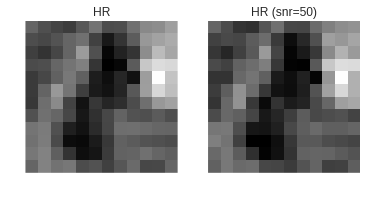

In [12]:
img_utils._isc(i_hr, Y[:, 1].reshape(i_hr.shape), b=1, titles=['HR', 'HR (snr='+str(SNR)+')'])
reload(mu)
mse_feta = mu.mse(i_hr[:,:,:,1], Y[:, 1].reshape(i_hr.shape)[:,:,:,1])
print 'mse, sqrt(mse)=', mse_feta, sqrt(mse_feta)
print 'coef_det=', mu.coef_det(i_hr[:,:,:,1], Y[:, 1].reshape(i_hr.shape)[:,:,:,1])


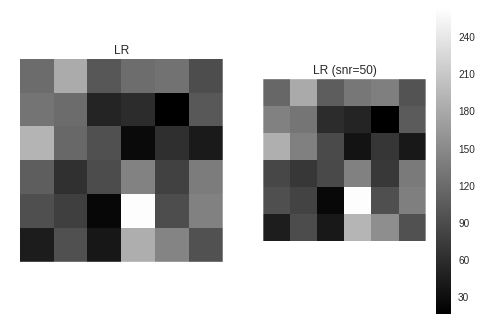

In [9]:
plt =img_utils._isc(i_lr, X[:, 9].reshape(i_lr.shape), b=0, titles=['LR', 'LR (snr='+str(SNR)+')'])
#plt.colorbar()

### Training

In [13]:
from scipy.sparse import csr_matrix, csc_matrix
import experimento1_funciones as e1f
#reload(e1f)

# Calculamos la matriz de downsampling
regr, Y_train , X_train, Y_test, X_test = e1f.train(Y,X)

regr.coef_ = csr_matrix(regr.coef_)
type(regr.coef_), regr.coef_.shape, SNR

Training set_training.shape= (10368, 9)  ->target.shape= (1296, 9)


(scipy.sparse.csr.csr_matrix, (1296, 10368), 50)

## Problem definition

$ \min_{Y_{hr}} \{ ||GY_{lr} - Y_{hr}||^2 \}$ st $Y_{hr} \geq 0$

In [14]:
Nx, Ny, Nz, bval = i_hr.shape
vhrb = Nx*Ny*Nz*bval
vlr = Nx*Ny*Nz/8

Yhr = cvx.Variable(vhrb, 1)
Ylr = i_lr.reshape((vlr*bval, 1))
G = cvx.Parameter(*regr.coef_.shape, value=regr.coef_)

# Form objective.
obj = cvx.Minimize(cvx.sum_squares(G*Yhr - Ylr))

# Create two constraints.
#constraints = [Yhr >= 0]

# Form and solve problem.
prob = cvx.Problem(obj)
prob, prob.is_dcp()

(Problem(Minimize(Expression(CONVEX, POSITIVE, (1, 1))), []), True)

### Motor ECOS (muy lento pero mas preciso)

### Motor SCS (mas veloz menos preciso)

In [15]:
start_time = time.time()

res = prob.solve(solver='SCS',verbose=True, max_iters=2100,eps=1.00e-01 )  # Returns the optimal value.
print "status:", prob.status
print "optimal value", prob.value
#print "optimal var", Yhr.value

seg = time.time() - start_time
minutes = int(seg / 60)
print("--- time of optimization : %d' %d'' --- num. snr: %d" % (minutes , seg%60, SNR))

WARN: m less than n, problem likely degenerate
----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 13436930, CG tol ~ 1/iter^(2.00)
eps = 1.00e-01, alpha = 1.50, max_iters = 2100, normalize = 1, scale = 1.00
Variables n = 10369, constraints m = 1298
Cones:	soc vars: 1298, soc blks: 1
Setup time: 6.39e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 3.97e+00  5.01e-01  9.77e-01 -4.24e+01  1.96e-02  0.00e+00  1.17e+00 
    20| 1.52e-02  2.29e-05  3.55e-02  4.48e-02  8.50e-02  7.71e-13  4.94e+00 
--------------------------------------------------------------------------

In [16]:
A = np.asarray(Yhr.value).reshape(i_hr.shape)
print 'shape=', A.shape, SNR


shape= (12, 12, 12, 6) 50


In [18]:
reload(mu)

<module 'utils.math_utils' from 'utils/math_utils.py'>

## Coef Det

In [19]:
import utils.math_utils as mu
import sklearn.metrics as skm

#cdet_img = mu.coef_det(i_hr, A,axis=3)
cdet_img = mu.coef_det_by_voxel_skl(i_hr, A)
cdet_layer = mu.coef_det_by_layer(i_hr, A)
#cdet_layer3 = mu.coef_det_by_layer_skl(i_hr, A)
print 'YO: cdet_img (max,min): ', (cdet_img.min(),cdet_img.max())
#print 'SKL: cdet_img3',  (cdet_img3.min(),cdet_img3.max())
print 'YO: cdet_layer', cdet_layer , (cdet_layer.min(),cdet_layer.max())
#print 'SKL cdet_layer3', cdet_layer3 , (cdet_layer3.min(),cdet_layer3.max())

YO: cdet_img (max,min):  (-24.857112776572592, 0.99420334195560711)
YO: cdet_layer [ 0.9131335   0.97513972  0.84900841  0.92880176  0.86623983  0.95617349] (0.84900841396164295, 0.9751397206920055)


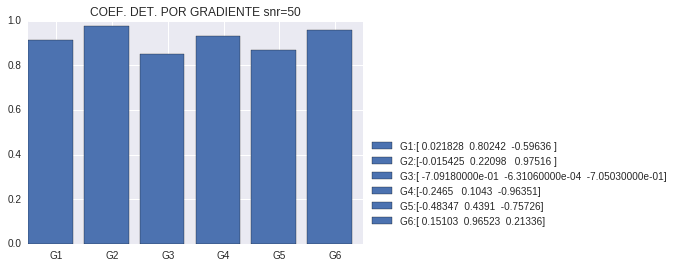

In [20]:
#ppv = lambda x1,x2,x3 : '('+str(x1)+',' +str(x2)+','+str(x3)+','')'

lala = plt.bar(range(0,cdet_layer.size), cdet_layer)
plt.xticks(arange(cdet_layer.size)+0.5,('G1','G2','G3','G4','G5','G6'))
plt.legend(lala,('G'+str(i+1) +":"+str(gdirections[i]) for i in range(0,6)) , loc=2, bbox_to_anchor=(1, 0.5))
plt.title('COEF. DET. POR GRADIENTE snr='+str(SNR))

#lala[0].set_label('G1')

saving cdet_snr50_voxels.png


('min,max = ', -0.56666274338903189, 0.99379974642457558)

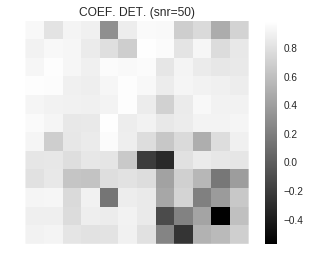

In [21]:
base_folder='/user/lgomez/home/Documents/tesis/optimizacion/img/' 
folder=base_folder + 'snr'+str(SNR)+'/cdet/'

plt.clf()
name = 'cdet_snr'+str(SNR)+'_voxels.png'
print 'saving', name   
plt=img_utils._is(cdet_img,title='COEF. DET. (snr='+str(SNR)+')')
#plt.clim(0.3,0.9)
#plt.colorbar()
plt.savefig(folder + name)
'min,max = ',cdet_img[:,cdet_img.shape[1]/2,:].min(), cdet_img[:,cdet_img.shape[1]/2,:].max()

(array([  1.,   1.,   3.,   0.,   2.,   4.,   7.,   9.,  28.,  89.]),
 array([-0.56666274, -0.41061649, -0.25457025, -0.098524  ,  0.05752225,
         0.2135685 ,  0.36961475,  0.525661  ,  0.68170725,  0.8377535 ,
         0.99379975]),
 <a list of 10 Patch objects>)

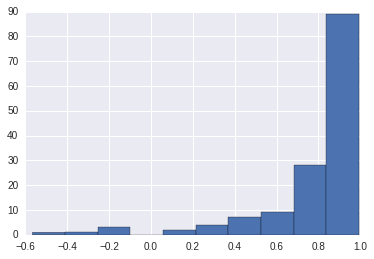

In [22]:
hist(cdet_img[:,cdet_img.shape[1]/2, :].flatten())
#hist(cdet_img.flatten())

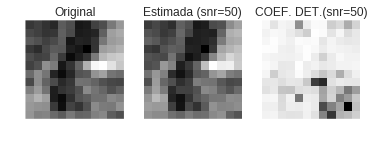

In [24]:
# PARA MOSTRAR UNA
plt=img_utils._isc3(i_hr, A, cdet_img, b=2,titles=['Original', 'Estimada (snr='+str(SNR)+')',  'COEF. DET.(snr='+str(SNR)+')'])
#plt.clim(-4,1)

saving cdet_snr50_voxels_b0_cmp.png /user/lgomez/home/Documents/tesis/optimizacion/img/snr50/mse/
saving cdet_snr50_voxels_b1_cmp.png /user/lgomez/home/Documents/tesis/optimizacion/img/snr50/mse/
saving cdet_snr50_voxels_b2_cmp.png /user/lgomez/home/Documents/tesis/optimizacion/img/snr50/mse/
saving cdet_snr50_voxels_b3_cmp.png /user/lgomez/home/Documents/tesis/optimizacion/img/snr50/mse/
saving cdet_snr50_voxels_b4_cmp.png /user/lgomez/home/Documents/tesis/optimizacion/img/snr50/mse/
saving cdet_snr50_voxels_b5_cmp.png /user/lgomez/home/Documents/tesis/optimizacion/img/snr50/mse/


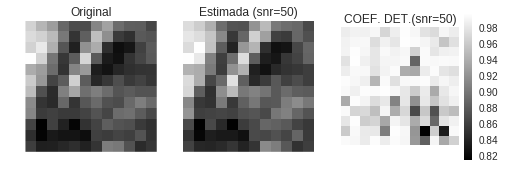

In [59]:
reload(img_utils)
from mpl_toolkits.axes_grid1 import make_axes_locatable

for b in range(0,6):
    plt.clf()
    name = 'cdet_snr'+str(SNR)+'_voxels_b'+ str(b) +'_cmp.png'
    print 'saving', name, folder
    titles = ['Original', 'Estimada (snr='+str(SNR)+')',  'COEF. DET.(snr='+str(SNR)+')']
    plt, _, _, im3=img_utils._isc3(i_hr, A, cdet_img, b=b, titles=titles)
    plt.colorbar(im3,fraction=0.056, pad=0.04)
    #im3.clim(0,1)
    plt.savefig(folder + name)
    
    

## MSE

In [25]:
mse_img = mu.mse(i_hr, A,axis=3)
mse_layer = [mu.mse(i_hr[:,:,:,i], A[:,:,:,i]) for i in range(0,6)]
print i_hr.shape, A.shape
norm_A , norm_i_hr = np.linalg.norm(A),  np.linalg.norm(i_hr)
print 'dif_norm =', np.linalg.norm(i_hr-A)  
print 'norm_i_hr =', norm_i_hr
print 'norm_A =', norm_A
print 'norm_A_sob_norm_i_hr =', norm_A/norm_i_hr

(12, 12, 12, 6) (12, 12, 12, 6)
dif_norm = 2.23266582212
norm_i_hr = 17.6669569251
norm_A = 19.5817802116
norm_A_sob_norm_i_hr = 1.10838444304


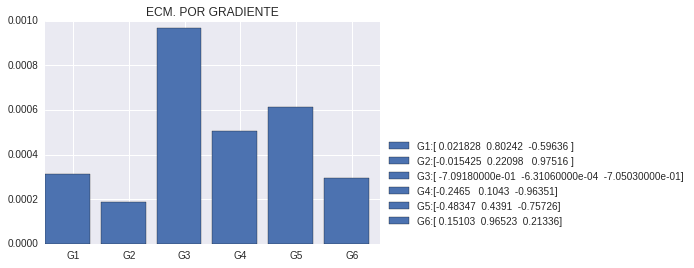

In [29]:
#ppv = lambda x1,x2,x3 : '('+str(x1)+',' +str(x2)+','+str(x3)+','')'

lolo = plt.bar(range(0,len(mse_layer)), mse_layer)
plt.xticks(arange(len(mse_layer))+0.5,('G1','G2','G3','G4','G5','G6'))
plt.legend(lolo,('G'+str(i+1) +":"+str(gdirections[i]) for i in range(0,6)) , loc=2, bbox_to_anchor=(1, 0.5))
plt.title('ECM. POR GRADIENTE')
#lala[0].set_label('G1')

saving mse_snr50_voxels.png
4.93280495278e-06 0.00193278421163


('min:max', 3.3622102209925539e-05, 0.0015404497517115588)

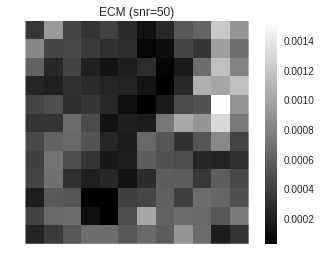

In [30]:
base_folder='/user/lgomez/home/Documents/tesis/optimizacion/img/' 
folder=base_folder + 'snr'+str(SNR)+'/mse/'

plt.clf()
name = 'mse_snr'+str(SNR)+'_voxels.png'
print 'saving', name   
plt=img_utils._is(mse_img,title='ECM (snr='+str(SNR)+')')
#plt.clim(0, 800)
plt.savefig(folder + name)

print mse_img.min(), mse_img.max()

'min:max', mse_img[:,mse_img.shape[1]/2, :].min(),mse_img[:,mse_img.shape[1]/2, :].max()

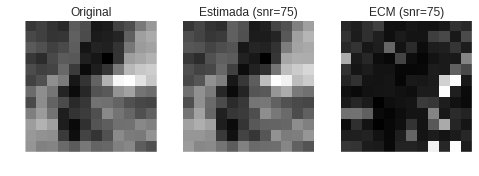

In [31]:
plt, _, _, im3=img_utils._isc3(i_hr, A, mse_img, b=2,titles=['Original', 'Estimada (snr='+str(SNR)+')',  'ECM (snr='+str(SNR)+')'])

plt.clim(0,250)

saving mse_snr50_voxels_b0_cmp.png
saving mse_snr50_voxels_b1_cmp.png
saving mse_snr50_voxels_b2_cmp.png
saving mse_snr50_voxels_b3_cmp.png
saving mse_snr50_voxels_b4_cmp.png
saving mse_snr50_voxels_b5_cmp.png


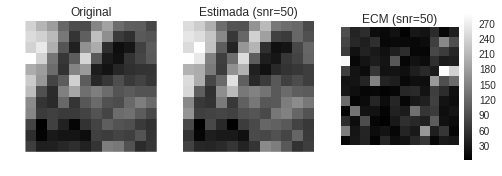

In [56]:
folder=base_folder + 'snr'+str(SNR)+'/mse/'
for b in range(0,6):
    plt.clf()
    name = 'mse_snr'+str(SNR)+'_voxels_b'+ str(b) +'_cmp.png'
    print 'saving', name
    titles = ['Original', 'Estimada (snr='+str(SNR)+')',  'ECM (snr='+str(SNR)+')']
    plt, _, _, im3=img_utils._isc3(i_hr, A, mse_img, b=b,titles=titles)
    plt.colorbar(im3,fraction=0.056, pad=0.04)
    #plt.clim(4,200)
    plt.savefig(folder + name)
    

### Result cmp

saving resul_snr50_b0_cmp.png
saving resul_snr50_b1_cmp.png
saving resul_snr50_b2_cmp.png
saving resul_snr50_b3_cmp.png
saving resul_snr50_b4_cmp.png
saving resul_snr50_b5_cmp.png


('Imagen con bvalor=2000', array([-0.015425,  0.22098 ,  0.97516 ]))

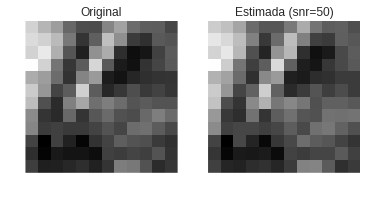

In [31]:
folder=base_folder + 'snr'+str(SNR)+'/'
for b in range(0,6):
    plt.clf()
    name = 'resul_snr'+str(SNR)+'_b'+ str(b) +'_cmp.png'
    print 'saving', name
    titles = ['Original', 'Estimada (snr='+str(SNR)+')']
    plt=img_utils._isc(i_hr, A, b=b, titles=titles)
    #plt.clim(-4,1)
    plt.savefig(folder + name)
    
('Imagen con bvalor=2000', gdirections[1])

# NO BORRAR

In [53]:
print 'mse_layer_snr100 =', mse_layer
print 'cdet_layer_snr100 =', cdet_layer

mse_layer_snr100 = [27.220444741448883, 95.207864739714694, 67.879196785303634, 53.893334054430582, 37.539338353298909, 44.547255060879401]
cdet_layer_snr100 = [ 0.99126412  0.98399461  0.98917208  0.99137239  0.99125107  0.99210082]


In [34]:
print 'mse_layer_snr'+str(SNR)+' =', mse_layer
print 'cdet_layer_snr'+str(SNR)+' =', cdet_layer

mse_layer_snr75 = [24.903095000753748, 64.459998276653664, 64.269193160808669, 97.59202966002924, 33.116074690944259, 37.173534933253528]
cdet_layer_snr75 = [ 0.99200783  0.98916363  0.98974794  0.9843768   0.99228195  0.99340834]


In [52]:
print 'mse_layer_snr'+str(SNR)+' =', mse_layer
print 'cdet_layer_snr'+str(SNR)+' =', cdet_layer

mse_layer_snr50 = [31.711632688301421, 66.392447765628674, 64.729100362041777, 75.545249462703325, 43.196339126857751, 117.19964987408039]
cdet_layer_snr50 = [ 0.98982276  0.98883877  0.98967458  0.9879062   0.98993264  0.97921799]


In [32]:
print 'mse_layer_snr'+str(SNR)+' =', mse_layer
print 'cdet_layer_snr'+str(SNR)+' =', cdet_layer

mse_layer_snr25 = [74.732087077878617, 597.04040861583007, 94.488468371191715, 530.63279378294988, 463.27448441659328, 93.750388263039085]
cdet_layer_snr25 = [ 0.97601617  0.89963155  0.98492744  0.91505266  0.89202907  0.98337605]


In [22]:
print 'mse_layer_snr'+str(SNR)+' =', mse_layer
print 'cdet_layer_snr'+str(SNR)+' =', cdet_layer

mse_layer_snr0 = [16840.573495370369, 32607.552662037036, 29843.239583333332, 31034.450810185186, 21723.137152777777, 25464.213541666668]
cdet_layer_snr0 = [-4.40466006 -4.48165497 -3.76051719 -3.9682078  -4.06280286 -3.51535118]


In [26]:
print 'mse_layer_snr'+str(SNR)+' =', mse_layer
print 'cdet_layer_snr'+str(SNR)+' =', cdet_layer

mse_layer_snr200 = [22.926268563299839, 152.41911256015663, 48.45190707071918, 49.818254635660452, 32.272639600281224, 40.417170069472405]
cdet_layer_snr200 = [ 0.99264225  0.97437683  0.99227108  0.99202475  0.99247853  0.99283317]


In [29]:
print 'mse_layer_snr'+str(SNR)+' =', mse_layer
print 'cdet_layer_snr'+str(SNR)+' =', cdet_layer

mse_layer_snr400 = [24.748734503082265, 97.595881400042416, 56.601868725436169, 50.827455890505377, 27.975157916068842, 49.93778267415064]
cdet_layer_snr400 = [ 0.99205737  0.98359316  0.99097101  0.99186319  0.9934801   0.99114496]
